In [1]:
from data_base import *

data = DataBase(summary=True, max_size=10**6)

Whole text size: 36161157 so used 1000000
Alphabet length: 160
Alphabet:  !"#%&'()*,-./0123456789:;<=>?@[]^_`abcdefghijklmnopqrstuvwxyz{|}~§«°·»½¾ßàáâäçèéêëíîïòóôöùúûüýœ̀́γεθιλοστυώабвгдежзийклмнопрстуфхцчшщъыьэюяёєіїљќѣ‑–—’“”„…№


In [2]:
import numpy as np
np.random.seed(80085)

input_len = 15

data.text_size = data.text_size - input_len
print('Train data size:', data.text_size)

X = np.zeros((data.text_size, input_len), dtype=np.float64)
Y = np.zeros((data.text_size, data.alph_len), dtype=np.int8)


def text_to_indexes(text):
    return np.array([data.letter_index[s] for s in text])


for i in tqdm(range(input_len, data.text_size-2)):
    fragment = data.whole_text[i-input_len : i]
    X[i-input_len] = text_to_indexes(fragment)
    
    letter_ind = data.letter_index[data.whole_text[i]]
    letter_ind_next = data.letter_index[data.whole_text[i+1]]
    letter_ind_next_1 = data.letter_index[data.whole_text[i+2]]
    Y[i-input_len][letter_ind] = 1
    Y[i-input_len][letter_ind_next] = 0.5
    Y[i-input_len][letter_ind_next_1] = 0.25
    
print('X shape:', X.shape)
print('Y shape:', Y.shape)

print(X)
print(Y)

Train data size: 999985


100%|██████████| 999968/999968 [00:15<00:00, 66496.32it/s] 


X shape: (999985, 15)
Y shape: (999985, 160)
[[129. 122. 112. ...  13.   3. 122.]
 [122. 112. 119. ...   3. 122. 126.]
 [112. 119. 122. ... 122. 126. 130.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, LeakyReLU, Conv1D

import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

batch_size = 64
dropout_val = 0.1
embending_size = 128

model = Sequential([
    Embedding(data.alph_len, embending_size, input_length=input_len),
    #Conv1D(32, 5, strides=1, padding='same'), LeakyReLU(),
    Dense(64), LeakyReLU(),
    Dropout(dropout_val),
    
    #Conv1D(64, 5, strides=1, padding='same'), LeakyReLU(),
    Dense(32), LeakyReLU(),
    Dropout(dropout_val),

    Flatten(),
    #Dense(data.alph_len, activation='softmax')
    Dense(data.alph_len), LeakyReLU(),
])

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X, Y, epochs=1, validation_split=0.2, batch_size=batch_size)

model.save('LP')

Num GPUs Available:  1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 128)           20480     
                                                                 
 dense (Dense)               (None, 15, 64)            8256      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 15, 64)            0         
                                                                 
 dropout (Dropout)           (None, 15, 64)            0         
                                                                 
 dense_1 (Dense)             (None, 15, 32)            2080      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 15, 32)            0         
                                                                 
 dropout_1 (Dropout)         (Non

(0.0, 1.0)

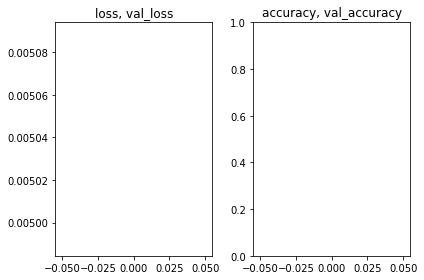

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title("loss, val_loss")

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].set_title("accuracy, val_accuracy")
axs[1].set_ylim([0, 1])

In [5]:
def match_to_letters(prediction):
    return {data.alphabet[i]: prediction[i] for i in range(data.alph_len)}

def letter_of_pred(prediction) -> str:
    return data.alphabet[prediction.argmax()]


letters_predicted = 0
predictability = 0
n = 100_000
#n = data.text_size

predictions = model.predict(X[:n])

for i in tqdm(range(n)):
    prediction = predictions[i]
    next_letter = data.whole_text[i + input_len]

    predictability += match_to_letters(prediction)[next_letter]
    letters_predicted += 1 if letter_of_pred(prediction) == next_letter else 0

predictability /= n - input_len
letters_predicted /= n - input_len
print('Predicted ', round(letters_predicted*100, 2), '% of letters')
print('Predictability of russian language is', round(predictability*100, 2), '%')

3125/3125 [==============================] - 10s 3ms/step


100%|██████████| 100000/100000 [00:05<00:00, 19177.79it/s]

Predicted  27.35 % of letters
Predictability of russian language is 13.68 %


In [8]:
#test_text = 'приветики, съешь ещё этих мягких французских булочек да выпей чаю'
#test_text = 'и снова седая ночь, и только ей доверяю я, знаешь седая ночь что-то та-а-ам'
#test_text = 'мне нужно это предложение, чтобы протестировать некий анализ йей!'
#test_text = prepare_text("Если посмотреть из чего получается оригинальная мысль, то можем выделить следующие факторы: личные ценности, культурный опыт, перспектива и взгляд на мир, эмоциональные и интуитивные компоненты. Из этого и складывается индивидуальность творца-человека. ИИ не обладает эмоциями. Но что из этого не может быть имитировано? Он не может обладать ничем из перечисленного, ведь это все присуще живым и мыслящим существам, а ИИ не живой; однако он может все это впитать и воссоздать в себе. Эти факторы – следствие всего пережитого, всего накопленного и отпечатанного опыта. А впитывать опыт – то, что ИИ и делают и способны делать это лучше нас и в гораздо большем объеме, чем способны люди, ведь ИИ не органичен физиологическими факторами.")
test_text = prepare_text("Если посмотреть из чего получается оригинальная мысль, то можем выделить следующие факторы: личные ценности, культурный опыт, перспектива и взгляд на мир, эмоциональные и интуитивные компоненты. Из этого и складывается индивидуальность творца-человека. ИИ не обладает эмоциями. Но что из этого не может быть имитировано? Он не может обладать ничем из перечисленного, ведь это все присуще живым и мыслящим существам, а ИИ не живой; однако он может все это впитать и воссоздать в себе. Эти факторы - следствие всего пережитого, всего накопленного и отпечатанного опыта. А впитывать опыт - то, что ИИ и делают и способны делать это лучше нас и в гораздо большем объеме, чем способны люди, ведь ИИ не органичен физиологическими факторами.")
test_text = prepare_text("ну тогда назови случайное число, и тогда будем считать что оно твое любимое")

r = test_text[:input_len]

for i in tqdm(range(input_len, len(test_text))):
    #frag = test_text[i-input_len : i]
    fragment = r[-input_len:]
    fragment = text_to_indexes(fragment)
    prediction = model.predict(np.array([fragment]), verbose=0)[0]

    if match_to_letters(prediction)[test_text[i]] > 0.10 and test_text[i] != ' ':
    #if letter_of_pred(prediction) == test_text[i] and test_text[i] != ' ':
        r += ''
    else:
        r += test_text[i]

print(r)
print('Original length:', len(test_text))
print('Compressed length:', len(r))
print('Compression:', len(r) / len(test_text))

100%|██████████| 60/60 [00:04<00:00, 13.69it/s]

ну тогда назови сучйн чсл, и тгд будм счь чо н тв любм
Original length: 75
Compressed length: 54
Compression: 0.72
